In [1]:
import numpy as np
import json
import codecs
import msticpy
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Dataset Overview

Used to be 125280 records. Left with 124883 sessions after dropping dulicated sessions.

In [2]:
msdat_dir = '/home/hpms/Microsoft.IoT-Dump1.json'
with codecs.open(msdat_dir, 'r', 'utf-8-sig') as f:
    msdat = json.load(f)
msdat = pd.DataFrame(msdat)
msdat['Commands'] = [tuple(session) for session in msdat['Commands']]
msdat = msdat.drop_duplicates(subset='Commands').reset_index(drop=True)  # drop duplicates
msdat['Commands'] = [list(session) for session in msdat['Commands']]
msdat

,Protocol,Commands,ID,TimesSeen,FirstSeen,LastSeen
0,Telnet,"[sh, /bin/busybox Uirusu, /bin/busybox ps; /bi...",61130d46117b4caf96eec5b4a5b6e4a1141aaad3e9076d...,692977,2019-07-09T15:48:24.45,2019-11-06T11:22:03.877
1,Telnet,"[sh, >/tmp/.ptmx && cd /tmp/, >/var/.ptmx && c...",285f4b2fc2ba5b1e737bc9002992a082008fe1361b334e...,43810830,2019-07-09T11:26:41.202,2019-11-06T11:20:48.611
2,Telnet,"[enable, system, shell, sh, >/tmp/.ptmx && cd ...",c6a071d3d8c39c321b0313f103e736105093bf90324719...,29292349,2019-07-09T11:26:42.295,2019-11-06T11:20:46.809
3,Telnet,"[enable, system, shell, sh, >/tmp/.ptmx && cd ...",d86e8e9f64827476f6f68292aa813561a9c764496b225b...,948780,2019-07-24T07:42:51.304,2019-11-06T11:21:47.753
4,Telnet,"[sh, >/tmp/.ptmx && cd /tmp/, >/var/.ptmx && c...",5541980fb93d397260790b84a92bc38fed061cda4950f4...,1472177,2019-07-24T07:42:51.304,2019-11-06T11:21:54.94
...,...,...,...,...,...,...
124878,Telnet,"[system, /bin/busybox PPHURT, /bin/busybox ps ...",63220f1fca58dfc145f016469da0a4621f9dff793044eb...,1,2019-08-07T14:58:14.528,2019-08-07T14:59:31.572
124879,Telnet,"[system, /bin/busybox PPHURT, /bin/busybox ps ...",54ad8ebf8c133669d654daeffebeede9cb94d1992deeab...,1,2019-08-07T14:58:42.339,2019-08-07T14:59:51.243
124880,Telnet,"[system, /bin/busybox PPHURT, /bin/busybox ps ...",0ace6d484c943304d91740888a3b59cd59bcb2436a3c47...,1,2019-08-07T14:57:57.016,2019-08-07T14:59:52.721
124881,Telnet,"[linuxshell, sh, shell, enable, system, /bin/b...",f86c6fb7b0e5dcc4b689c6dcf7b3f64aadce1a3c7ab544...,1,2019-08-07T14:58:44.716,2019-08-07T15:00:37.483


### Inverstigate commands

In [3]:
sessions_list = []  # list of sessions
commands_list = []  # list of all commands
for session in msdat['Commands']:
    sessions_list += [session]
    commands_list += session  

In [4]:
commands_counts = dict()  # dictionary, counts of commands
for command in commands_list:
    commands_counts[command] = commands_counts.get(command, 0)+1

In [5]:
longest_session = 0
for session in sessions_list:
    if len(session) > longest_session:
        longest_session = len(session)
print('The longest session has {} commands'.format(longest_session))

The longest session has 723 commands


In [6]:
print('There are {} commands out of {} records.'.format(len(commands_counts), len(commands_list)))

There are 56714 commands out of 8208659 records.


In [7]:
print('Top 10 frequent commands are \n{}'
      .format(sorted(commands_counts.items(), key=lambda item: item[1], reverse=True)[:10]))

Top 10 frequent commands are 
[('/bin/busybox SEFA', 156326), ('rm /dev/.t; rm /dev/.sh; rm /dev/.human', 149871), ('rm /proc/sys/fs/binfmt_misc/.t; rm /proc/sys/fs/binfmt_misc/.sh; rm /proc/sys/fs/binfmt_misc/.human', 149222), ("/bin/busybox echo -e '\\x6b\\x61\\x6d\\x69/dev' > /dev/.nippon; /bin/busybox cat /dev/.nippon; /bin/busybox rm /dev/.nippon", 142892), ("/bin/busybox echo -e '\\x6b\\x61\\x6d\\x69/proc/sys/fs/binfmt_misc' > /proc/sys/fs/binfmt_misc/.nippon; /bin/busybox cat /proc/sys/fs/binfmt_misc/.nippon; /bin/busybox rm /proc/sys/fs/binfmt_misc/.nippon", 141675), ('system', 92631), ('enable', 77127), ('rm /proc/.t; rm /proc/.sh; rm /proc/.human', 75200), ('rm /sys/.t; rm /sys/.sh; rm /sys/.human', 75185), ('rm /dev/shm/.t; rm /dev/shm/.sh; rm /dev/shm/.human', 75179)]


In [8]:
# to investigate the frequency of commands
for n in range(1, 22, 2):
    commands_n_list = []
    for key, val in list(commands_counts.items()):
        if val >= n:
            commands_n_list += [key]
    print('{} commands appear no fewer than {} times'.format(len(commands_n_list), n))

56714 commands appear no fewer than 1 times
23278 commands appear no fewer than 3 times
15631 commands appear no fewer than 5 times
11469 commands appear no fewer than 7 times
7176 commands appear no fewer than 9 times
4098 commands appear no fewer than 11 times
2414 commands appear no fewer than 13 times
1649 commands appear no fewer than 15 times
1306 commands appear no fewer than 17 times
1180 commands appear no fewer than 19 times
1126 commands appear no fewer than 21 times


### Sequences of Commands

In [9]:
def make_seq_list(n, sessions_list):
    """
    create list of sequences of length n in a session
    """
    seq_list = []
    for seq in sessions_list:
        if len(seq) >= n:
            for m in range(len(seq)-n+1):
                seq_list += [tuple(seq[m:m+n])]
    
    return seq_list

In [10]:
n = 5
seq_list = make_seq_list(n, sessions_list)
print('There are {} seqs of length {} out of {} records.'.format(len(set(seq_list)), n, len(seq_list)))

There are 287035 seqs of length 5 out of 7710284 records.


In [11]:
def make_seq_counts(n, sessions_list):
    """
    create dictionary with records counts of sequences of length n
    """
    seq_counts = dict()  # dictionary, count of sequences
    seq_list = make_seq_list(n, sessions_list)
    for i in seq_list:
        seq_counts[i] = seq_counts.get(i, 0)+1
    
    return seq_counts

def sort_counts(counts_dict):
    """
    Sort dictionary of counts from high to low, return a list of tuples
    """
    return sorted(counts_dict.items(), key=lambda item: item[1], reverse=True)

In [12]:
t10seq = sort_counts(make_seq_counts(n,sessions_list))[:10]
print('Top 10 frequent sequence of commands of length {} are \n{}'.format(n, t10seq))

Top 10 frequent sequence of commands of length 5 are 
[(('rm /.t; rm /.sh; rm /.human', 'rm /dev/.t; rm /dev/.sh; rm /dev/.human', 'rm /sys/.t; rm /sys/.sh; rm /sys/.human', 'rm /proc/.t; rm /proc/.sh; rm /proc/.human', 'rm /dev/shm/.t; rm /dev/shm/.sh; rm /dev/shm/.human'), 73846), (('rm /sys/.t; rm /sys/.sh; rm /sys/.human', 'rm /proc/.t; rm /proc/.sh; rm /proc/.human', 'rm /dev/shm/.t; rm /dev/shm/.sh; rm /dev/shm/.human', 'rm /dev/pts/.t; rm /dev/pts/.sh; rm /dev/pts/.human', 'rm /run/.t; rm /run/.sh; rm /run/.human'), 73810), (('rm /dev/.t; rm /dev/.sh; rm /dev/.human', 'rm /sys/.t; rm /sys/.sh; rm /sys/.human', 'rm /proc/.t; rm /proc/.sh; rm /proc/.human', 'rm /dev/shm/.t; rm /dev/shm/.sh; rm /dev/shm/.human', 'rm /dev/pts/.t; rm /dev/pts/.sh; rm /dev/pts/.human'), 73800), (('rm /dev/shm/.t; rm /dev/shm/.sh; rm /dev/shm/.human', 'rm /dev/pts/.t; rm /dev/pts/.sh; rm /dev/pts/.human', 'rm /run/.t; rm /run/.sh; rm /run/.human', 'rm /run/lock/.t; rm /run/lock/.sh; rm /run/lock/.human

### Initial commands

In [13]:
def find_initial_commands_idx(n, sessions_list):
    """
    find first n commands with respective index in the sessions_list
    """
    initial_commands_idx = dict()
    for i in range(len(sessions_list)):
        initial_commands_idx[tuple(sessions_list[i][:n])] = initial_commands_idx.get(tuple(sessions_list[i][:n]), [])+[i]
    
    return initial_commands_idx

def sort_idx(idx_dic):
    """
    sort dictionary by length of index from high to low
    """
    
    return sorted(idx_dic.items(), key=lambda item: len(item[1]), reverse=True)

In [14]:
def make_initial_commands_dat(initialcommandidx, seq_counts, sessions_list):
    """
    This function create dataframe to model initial commands and sequences
    
    :param initialcommandidx: list of tuples containing initial commands and and idx
    :param seq_counts: list of tuple containing sequences and counts
    :param sessions_list: list of sessions
    
    :return initial_command_dat: dataframe
    """
    m, n = len(initialcommandidx), len(seq_counts)
    seq_length = len(seq_counts[0][0])  # length of sequence
    # create dataframe
    initial_command_dat = pd.DataFrame()
    initial_command_dat['Initial Commands'] = [command for command, _ in initialcommandidx]*n
    initial_command_dat['Initial Commands Index'] = [i for i in range(m)]*n
    initial_command_dat['Initial Commands Appearance'] = [len(idx) for _, idx in initialcommandidx]*n
    initial_command_dat['Initial Commands Appearance Freq'] = \
    initial_command_dat.loc[:,'Initial Commands Appearance']/len(sessions_list)
    initial_command_dat['Seq'] = np.zeros(m*n)
    initial_command_dat['Seq'] = initial_command_dat['Seq'].astype('object')
    initial_command_dat['Seq Index'] = np.zeros(m*n, dtype=int)
    initial_command_dat['Seq Appearance'] = np.zeros(m*n, dtype=int)
    
    for i in range(m):
        for j in range(n):
            initial_command_dat.at[j*m+i, 'Seq'] = seq_counts[j][0]
            initial_command_dat.loc[j*m+i, 'Seq Index'] = j

    for i in range(m):
        temp_sessions_list = [sessions_list[k] for k in initialcommandidx[i][1]]
        temp_seq_list = make_seq_list(seq_length, temp_sessions_list)
        for j in range(n):
            seq = seq_counts[j][0]
            initial_command_dat.loc[j*m+i,'Seq Appearance'] = temp_seq_list.count(seq)

    initial_command_dat['Seq Appearance Freq'] = initial_command_dat.loc[:,'Seq Appearance']\
    /initial_command_dat.loc[:,'Initial Commands Appearance']
    
    return initial_command_dat

**I use sequence of length 12 and initial 3 commands in each session.**

In [15]:
# sequence of length 12
sorted_seq_counts = sort_counts(make_seq_counts(12,sessions_list))  # sort sequences

In [16]:
# select top 100 frequent sequences
selected_seq_counts = sorted_seq_counts[:100]

In [51]:
len(find_initial_commands_idx(3,sessions_list))

19805

In [17]:
# top 10 frequent initial commands
initialcommandidx = sort_idx(find_initial_commands_idx(3,sessions_list))[:10]

In [18]:
# dataframe
initial_commands_dat = make_initial_commands_dat(initialcommandidx, selected_seq_counts, sessions_list)

In [19]:
initial_commands_dat.head()

,Initial Commands,Initial Commands Index,Initial Commands Appearance,Initial Commands Appearance Freq,Seq,Seq Index,Seq Appearance,Seq Appearance Freq
0,"(sh, .., linuxshell)",0,22933,0.183636,"(rm /.t; rm /.sh; rm /.human, rm /dev/.t; rm /...",0,15527,0.677059
1,"(sh, linuxshell, bah)",1,14144,0.113258,"(rm /.t; rm /.sh; rm /.human, rm /dev/.t; rm /...",0,8649,0.611496
2,"(linuxshell, sh, shell)",2,11777,0.094304,"(rm /.t; rm /.sh; rm /.human, rm /dev/.t; rm /...",0,6681,0.567292
3,"(system, /bin/busybox PPHURT, /bin/busybox ps ...",3,10696,0.085648,"(rm /.t; rm /.sh; rm /.human, rm /dev/.t; rm /...",0,5952,0.556470
4,"(enable, shell, sh)",4,10340,0.082797,"(rm /.t; rm /.sh; rm /.human, rm /dev/.t; rm /...",0,5547,0.536460


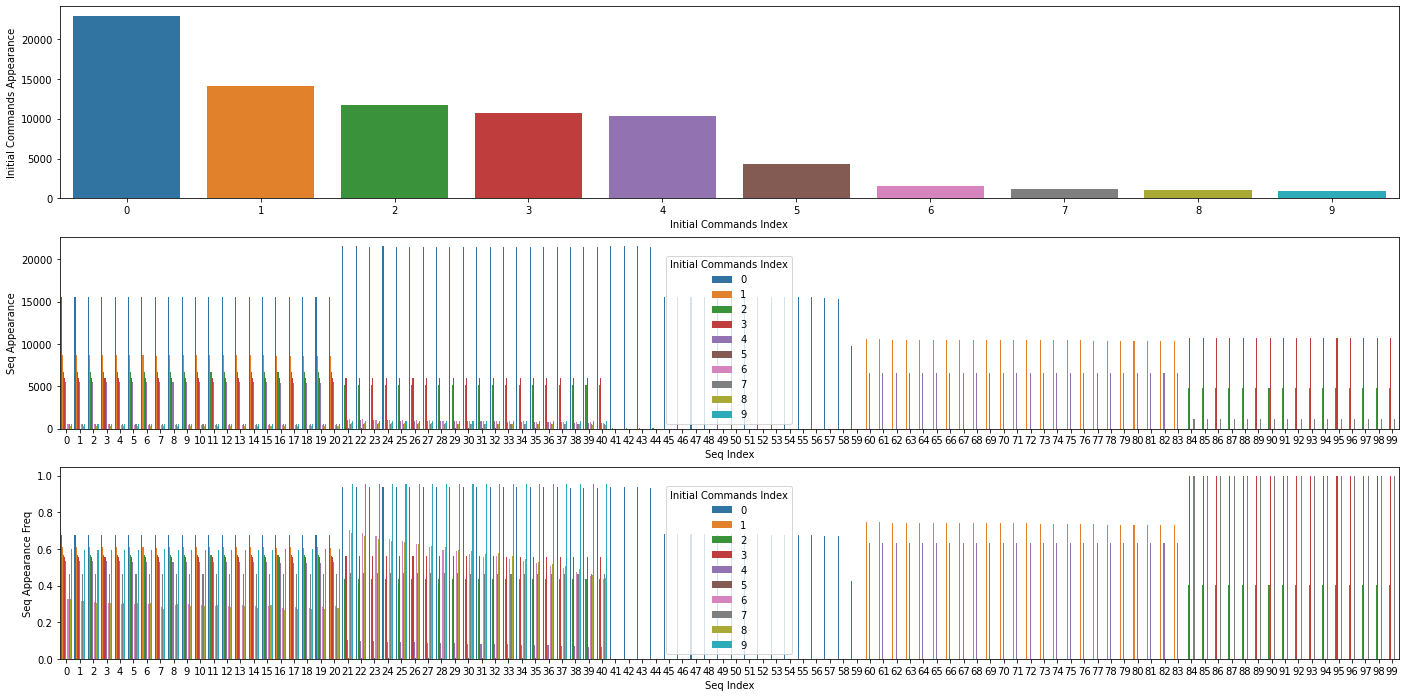

In [20]:
# plot
fig, ax = plt.subplots(3,1, figsize=(24,12))
sns.barplot(x='Initial Commands Index', y='Initial Commands Appearance', data=initial_commands_dat, ax=ax[0])
sns.barplot(x='Seq Index', y='Seq Appearance', hue='Initial Commands Index', data=initial_commands_dat, ax=ax[1])

sns.barplot(x='Seq Index', y='Seq Appearance Freq', hue='Initial Commands Index', data=initial_commands_dat, ax=ax[2])
plt.show()

Each Seq/Initial Commands Index represents a Sequence/Initial Commands. 

Initial Commands Appearance is the number of sessions possessing each initial commands

Seq Appearance is the number of sequences whose sessions have desired initial commands

Seq Appearance Freq = Seq Appearance / Initial Commands Appearance

For the top 100 frequent sequences of commands, we can see about 5 clusterings. Next we can have a detailed look of each cluster.

#### Seq Index 0-20

I have checked that Seq index 0-19 only have commands start with rm, and seem to be connected in a large sequence of commands. Seq index 20 is the only sequence with one command starting without rm.

In [21]:
sorted_seq_counts[0]

(('rm /.t; rm /.sh; rm /.human',
  'rm /dev/.t; rm /dev/.sh; rm /dev/.human',
  'rm /sys/.t; rm /sys/.sh; rm /sys/.human',
  'rm /proc/.t; rm /proc/.sh; rm /proc/.human',
  'rm /dev/shm/.t; rm /dev/shm/.sh; rm /dev/shm/.human',
  'rm /dev/pts/.t; rm /dev/pts/.sh; rm /dev/pts/.human',
  'rm /run/.t; rm /run/.sh; rm /run/.human',
  'rm /run/lock/.t; rm /run/lock/.sh; rm /run/lock/.human',
  'rm /sys/fs/cgroup/.t; rm /sys/fs/cgroup/.sh; rm /sys/fs/cgroup/.human',
  'rm /sys/fs/cgroup/systemd/.t; rm /sys/fs/cgroup/systemd/.sh; rm /sys/fs/cgroup/systemd/.human',
  'rm /sys/fs/cgroup/cpu,cpuacct/.t; rm /sys/fs/cgroup/cpu,cpuacct/.sh; rm /sys/fs/cgroup/cpu,cpuacct/.human',
  'rm /sys/fs/cgroup/cpuset/.t; rm /sys/fs/cgroup/cpuset/.sh; rm /sys/fs/cgroup/cpuset/.human'),
 72520)

In [22]:
sorted_seq_counts[20]

(('rm /sys/fs/cgroup/perf_event/.t; rm /sys/fs/cgroup/perf_event/.sh; rm /sys/fs/cgroup/perf_event/.human',
  'rm /proc/sys/fs/binfmt_misc/.t; rm /proc/sys/fs/binfmt_misc/.sh; rm /proc/sys/fs/binfmt_misc/.human',
  'rm /dev/mqueue/.t; rm /dev/mqueue/.sh; rm /dev/mqueue/.human',
  'rm /sys/kernel/debug/.t; rm /sys/kernel/debug/.sh; rm /sys/kernel/debug/.human',
  'rm /sys/fs/fuse/connections/.t; rm /sys/fs/fuse/connections/.sh; rm /sys/fs/fuse/connections/.human',
  'rm /sys/kernel/config/.t; rm /sys/kernel/config/.sh; rm /sys/kernel/config/.human',
  'rm /var/ngx_pagespeed_cache/.t; rm /var/ngx_pagespeed_cache/.sh; rm /var/ngx_pagespeed_cache/.human',
  'rm /run/cgmanager/fs/.t; rm /run/cgmanager/fs/.sh; rm /run/cgmanager/fs/.human',
  'rm /proc/sys/fs/binfmt_misc/.t; rm /proc/sys/fs/binfmt_misc/.sh; rm /proc/sys/fs/binfmt_misc/.human',
  'rm /run/user/1000/.t; rm /run/user/1000/.sh; rm /run/user/1000/.human',
  'rm /dev/.t; rm /dev/.sh; rm /dev/.human',
  'cd /'),
 72170)

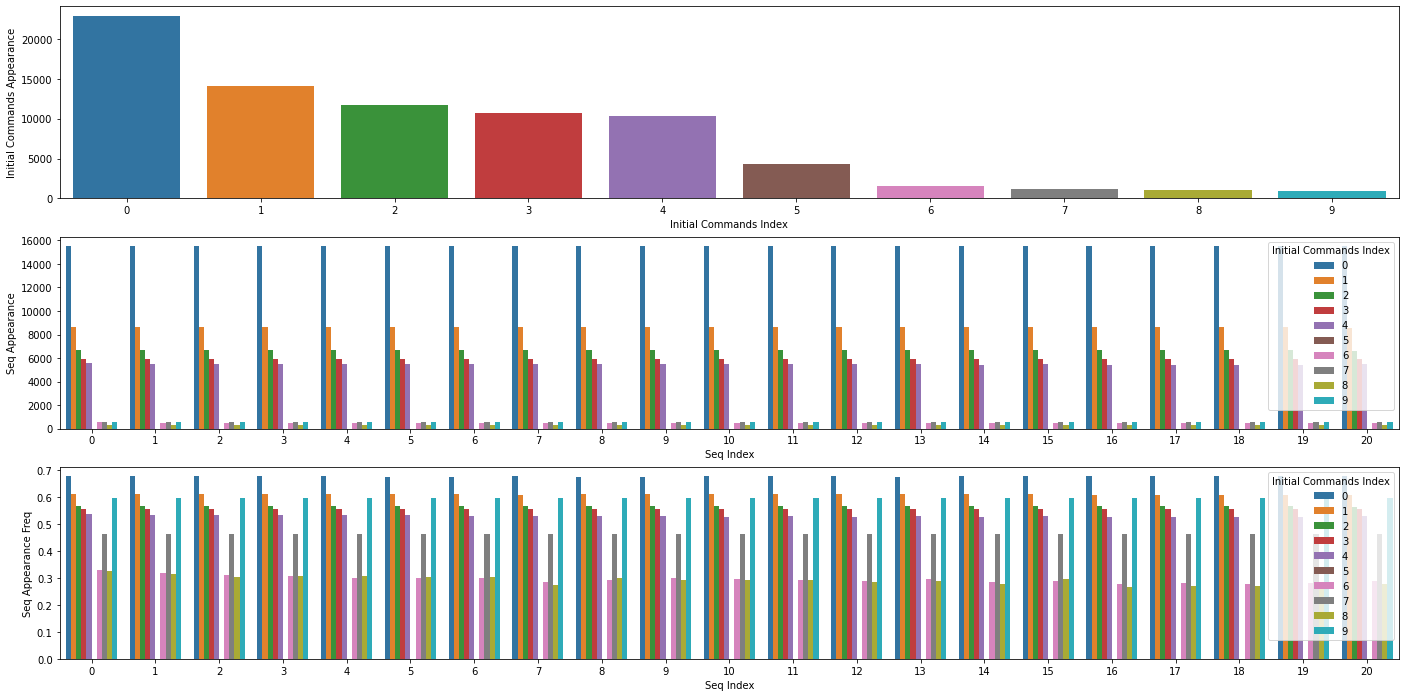

In [23]:
# select top 0-20 frequent sequences
selected_seq_counts_021 = sorted_seq_counts[:21]
# dataframe
initial_commands_dat_021 = make_initial_commands_dat(initialcommandidx, selected_seq_counts_021, sessions_list)
# plot
fig, ax = plt.subplots(3,1, figsize=(24,12))
sns.barplot(x='Initial Commands Index', y='Initial Commands Appearance', data=initial_commands_dat_021, ax=ax[0])
sns.barplot(x='Seq Index', y='Seq Appearance', hue='Initial Commands Index', data=initial_commands_dat_021, ax=ax[1])

sns.barplot(x='Seq Index', y='Seq Appearance Freq', hue='Initial Commands Index', data=initial_commands_dat_021, ax=ax[2])
plt.show()

The seq frequencies are various for different initial commands

#### Seq 21-40

I have checked that Seq index 21-40 only have commands start with /bin/busybox echo -e, and seem to be connected in a large sequence of commands. Seq index 41 has a huge drop of times of appearance.

In [24]:
sorted_seq_counts[21]

(("/bin/busybox echo -e '\\x6b\\x61\\x6d\\x69' > /.nippon; /bin/busybox cat /.nippon; /bin/busybox rm /.nippon",
  "/bin/busybox echo -e '\\x6b\\x61\\x6d\\x69/dev' > /dev/.nippon; /bin/busybox cat /dev/.nippon; /bin/busybox rm /dev/.nippon",
  "/bin/busybox echo -e '\\x6b\\x61\\x6d\\x69/sys' > /sys/.nippon; /bin/busybox cat /sys/.nippon; /bin/busybox rm /sys/.nippon",
  "/bin/busybox echo -e '\\x6b\\x61\\x6d\\x69/proc' > /proc/.nippon; /bin/busybox cat /proc/.nippon; /bin/busybox rm /proc/.nippon",
  "/bin/busybox echo -e '\\x6b\\x61\\x6d\\x69/dev/shm' > /dev/shm/.nippon; /bin/busybox cat /dev/shm/.nippon; /bin/busybox rm /dev/shm/.nippon",
  "/bin/busybox echo -e '\\x6b\\x61\\x6d\\x69/dev/pts' > /dev/pts/.nippon; /bin/busybox cat /dev/pts/.nippon; /bin/busybox rm /dev/pts/.nippon",
  "/bin/busybox echo -e '\\x6b\\x61\\x6d\\x69/run' > /run/.nippon; /bin/busybox cat /run/.nippon; /bin/busybox rm /run/.nippon",
  "/bin/busybox echo -e '\\x6b\\x61\\x6d\\x69/run/lock' > /run/lock/.nippon; 

In [25]:
sorted_seq_counts[40]

(("/bin/busybox echo -e '\\x6b\\x61\\x6d\\x69/sys/fs/cgroup/freezer' > /sys/fs/cgroup/freezer/.nippon; /bin/busybox cat /sys/fs/cgroup/freezer/.nippon; /bin/busybox rm /sys/fs/cgroup/freezer/.nippon",
  "/bin/busybox echo -e '\\x6b\\x61\\x6d\\x69/sys/fs/cgroup/perf_event' > /sys/fs/cgroup/perf_event/.nippon; /bin/busybox cat /sys/fs/cgroup/perf_event/.nippon; /bin/busybox rm /sys/fs/cgroup/perf_event/.nippon",
  "/bin/busybox echo -e '\\x6b\\x61\\x6d\\x69/proc/sys/fs/binfmt_misc' > /proc/sys/fs/binfmt_misc/.nippon; /bin/busybox cat /proc/sys/fs/binfmt_misc/.nippon; /bin/busybox rm /proc/sys/fs/binfmt_misc/.nippon",
  "/bin/busybox echo -e '\\x6b\\x61\\x6d\\x69/dev/mqueue' > /dev/mqueue/.nippon; /bin/busybox cat /dev/mqueue/.nippon; /bin/busybox rm /dev/mqueue/.nippon",
  "/bin/busybox echo -e '\\x6b\\x61\\x6d\\x69/sys/kernel/debug' > /sys/kernel/debug/.nippon; /bin/busybox cat /sys/kernel/debug/.nippon; /bin/busybox rm /sys/kernel/debug/.nippon",
  "/bin/busybox echo -e '\\x6b\\x61\\x6

In [26]:
print('Times of appearance of seq index 40 is {}, while index 41 is {}.'
      .format(sorted_seq_counts[40][1], sorted_seq_counts[41][1]))

Times of appearance of seq index 40 is 68936, while index 41 is 48390.


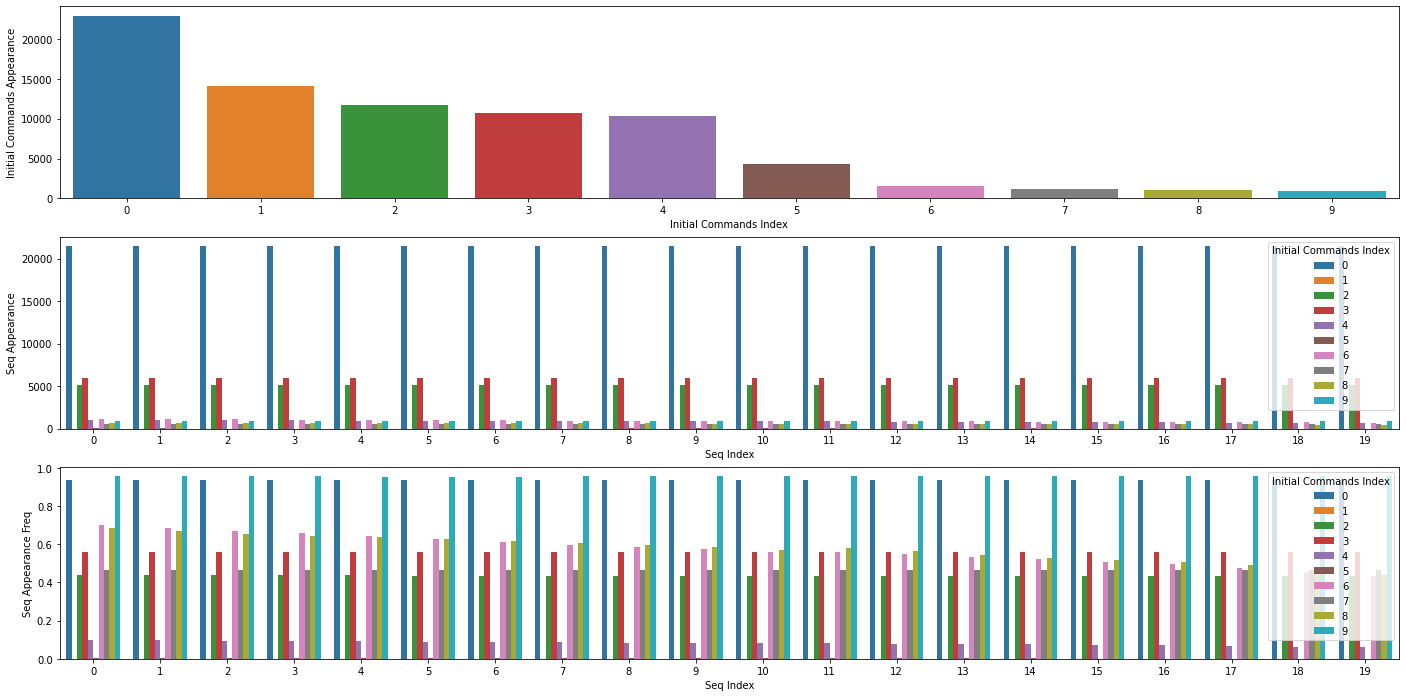

In [27]:
# select top 21-40 frequent sequences
selected_seq_counts_2241 = sorted_seq_counts[21:41]
# dataframe
initial_commands_dat_2241 = make_initial_commands_dat(initialcommandidx, selected_seq_counts_2241, sessions_list)
# plot
fig, ax = plt.subplots(3,1, figsize=(24,12))
sns.barplot(x='Initial Commands Index', y='Initial Commands Appearance', data=initial_commands_dat_2241, ax=ax[0])
sns.barplot(x='Seq Index', y='Seq Appearance', hue='Initial Commands Index', data=initial_commands_dat_2241, ax=ax[1])

sns.barplot(x='Seq Index', y='Seq Appearance Freq', hue='Initial Commands Index', data=initial_commands_dat_2241, ax=ax[2])
plt.show()

#### Seq 41-59

This can be divided into 3 small clusters. 41-44, 45-58 and 59. Many of them seem to be connected.

In [28]:
sorted_seq_counts[41]

(('/bin/busybox SEFA',
  '/bin/busybox ps; /bin/busybox SEFA',
  '/bin/busybox cat /proc/mounts; /bin/busybox SEFA',
  "/bin/busybox echo -e '\\x6b\\x61\\x6d\\x69' > /.nippon; /bin/busybox cat /.nippon; /bin/busybox rm /.nippon",
  "/bin/busybox echo -e '\\x6b\\x61\\x6d\\x69/dev' > /dev/.nippon; /bin/busybox cat /dev/.nippon; /bin/busybox rm /dev/.nippon",
  "/bin/busybox echo -e '\\x6b\\x61\\x6d\\x69/sys' > /sys/.nippon; /bin/busybox cat /sys/.nippon; /bin/busybox rm /sys/.nippon",
  "/bin/busybox echo -e '\\x6b\\x61\\x6d\\x69/proc' > /proc/.nippon; /bin/busybox cat /proc/.nippon; /bin/busybox rm /proc/.nippon",
  "/bin/busybox echo -e '\\x6b\\x61\\x6d\\x69/dev/shm' > /dev/shm/.nippon; /bin/busybox cat /dev/shm/.nippon; /bin/busybox rm /dev/shm/.nippon",
  "/bin/busybox echo -e '\\x6b\\x61\\x6d\\x69/dev/pts' > /dev/pts/.nippon; /bin/busybox cat /dev/pts/.nippon; /bin/busybox rm /dev/pts/.nippon",
  "/bin/busybox echo -e '\\x6b\\x61\\x6d\\x69/run' > /run/.nippon; /bin/busybox cat /run/

In [29]:
sorted_seq_counts[45]

(("/bin/busybox echo -e '\\x6b\\x61\\x6d\\x69/proc/sys/fs/binfmt_misc' > /proc/sys/fs/binfmt_misc/.nippon; /bin/busybox cat /proc/sys/fs/binfmt_misc/.nippon; /bin/busybox rm /proc/sys/fs/binfmt_misc/.nippon",
  "/bin/busybox echo -e '\\x6b\\x61\\x6d\\x69/dev/mqueue' > /dev/mqueue/.nippon; /bin/busybox cat /dev/mqueue/.nippon; /bin/busybox rm /dev/mqueue/.nippon",
  "/bin/busybox echo -e '\\x6b\\x61\\x6d\\x69/sys/kernel/debug' > /sys/kernel/debug/.nippon; /bin/busybox cat /sys/kernel/debug/.nippon; /bin/busybox rm /sys/kernel/debug/.nippon",
  "/bin/busybox echo -e '\\x6b\\x61\\x6d\\x69/sys/fs/fuse/connections' > /sys/fs/fuse/connections/.nippon; /bin/busybox cat /sys/fs/fuse/connections/.nippon; /bin/busybox rm /sys/fs/fuse/connections/.nippon",
  "/bin/busybox echo -e '\\x6b\\x61\\x6d\\x69/sys/kernel/config' > /sys/kernel/config/.nippon; /bin/busybox cat /sys/kernel/config/.nippon; /bin/busybox rm /sys/kernel/config/.nippon",
  "/bin/busybox echo -e '\\x6b\\x61\\x6d\\x69/var/ngx_pages

In [30]:
sorted_seq_counts[58]

(('rm /sys/kernel/debug/.t; rm /sys/kernel/debug/.sh; rm /sys/kernel/debug/.human',
  'rm /sys/fs/fuse/connections/.t; rm /sys/fs/fuse/connections/.sh; rm /sys/fs/fuse/connections/.human',
  'rm /sys/kernel/config/.t; rm /sys/kernel/config/.sh; rm /sys/kernel/config/.human',
  'rm /var/ngx_pagespeed_cache/.t; rm /var/ngx_pagespeed_cache/.sh; rm /var/ngx_pagespeed_cache/.human',
  'rm /run/cgmanager/fs/.t; rm /run/cgmanager/fs/.sh; rm /run/cgmanager/fs/.human',
  'rm /proc/sys/fs/binfmt_misc/.t; rm /proc/sys/fs/binfmt_misc/.sh; rm /proc/sys/fs/binfmt_misc/.human',
  'rm /run/user/1000/.t; rm /run/user/1000/.sh; rm /run/user/1000/.human',
  'rm /dev/.t; rm /dev/.sh; rm /dev/.human',
  'cd /',
  '/bin/busybox cp /bin/echo sefaexecbi; >sefaexecbi; /bin/busybox chmod 777 sefaexecbi; /bin/busybox SEFA',
  '/bin/busybox cat /bin/echo',
  '/bin/busybox SEFA'),
 34489)

In [31]:
sorted_seq_counts[59]

(('rm /sys/fs/fuse/connections/.t; rm /sys/fs/fuse/connections/.sh; rm /sys/fs/fuse/connections/.human',
  'rm /sys/kernel/config/.t; rm /sys/kernel/config/.sh; rm /sys/kernel/config/.human',
  'rm /var/ngx_pagespeed_cache/.t; rm /var/ngx_pagespeed_cache/.sh; rm /var/ngx_pagespeed_cache/.human',
  'rm /run/cgmanager/fs/.t; rm /run/cgmanager/fs/.sh; rm /run/cgmanager/fs/.human',
  'rm /proc/sys/fs/binfmt_misc/.t; rm /proc/sys/fs/binfmt_misc/.sh; rm /proc/sys/fs/binfmt_misc/.human',
  'rm /run/user/1000/.t; rm /run/user/1000/.sh; rm /run/user/1000/.human',
  'rm /dev/.t; rm /dev/.sh; rm /dev/.human',
  'cd /',
  '/bin/busybox cp /bin/echo sefaexecbi; >sefaexecbi; /bin/busybox chmod 777 sefaexecbi; /bin/busybox SEFA',
  '/bin/busybox cat /bin/echo',
  '/bin/busybox SEFA',
  '/bin/busybox wget; /bin/busybox tftp; /bin/busybox SEFA'),
 21938)

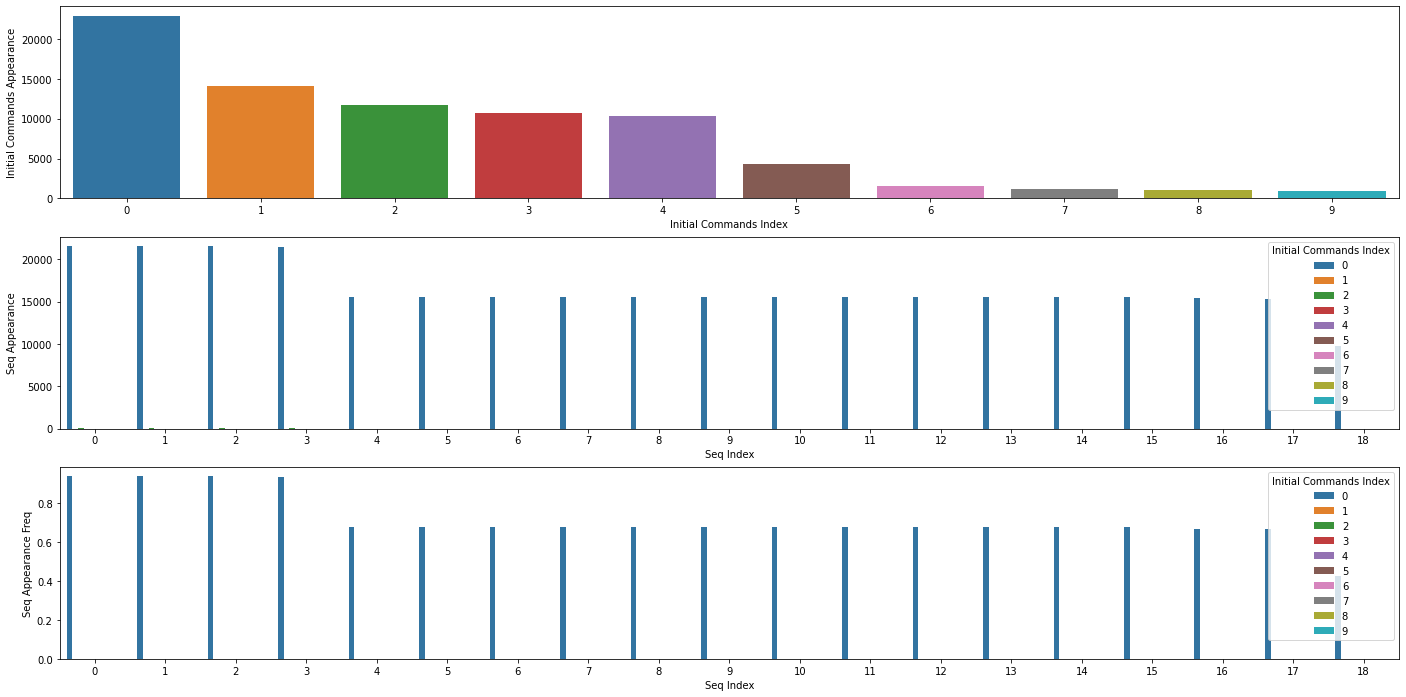

In [32]:
# select top 41-59 frequent sequences
selected_seq_counts_4159 = sorted_seq_counts[41:60]
# dataframe
initial_commands_dat_4159 = make_initial_commands_dat(initialcommandidx, selected_seq_counts_4159, sessions_list)
# plot
fig, ax = plt.subplots(3,1, figsize=(24,12))
sns.barplot(x='Initial Commands Index', y='Initial Commands Appearance', data=initial_commands_dat_4159, ax=ax[0])
sns.barplot(x='Seq Index', y='Seq Appearance', hue='Initial Commands Index', data=initial_commands_dat_4159, ax=ax[1])

sns.barplot(x='Seq Index', y='Seq Appearance Freq', hue='Initial Commands Index', data=initial_commands_dat_4159, ax=ax[2])
plt.show()

#### Seq 60-83

looks similar

In [33]:
sorted_seq_counts[60]

(('/bin/busybox Ex0',
  '/bin/busybox ps; /bin/busybox Ex0',
  '/bin/busybox cat /proc/mounts; /bin/busybox Ex0',
  "/bin/busybox echo -e '\\x45\\x78\\x30\\x31' > /.nipped; /bin/busybox cat /.nipped; /bin/busybox rm /.nipped",
  "/bin/busybox echo -e '\\x45\\x78\\x30\\x31/dev' > /dev/.nipped; /bin/busybox cat /dev/.nipped; /bin/busybox rm /dev/.nipped",
  "/bin/busybox echo -e '\\x45\\x78\\x30\\x31/sys' > /sys/.nipped; /bin/busybox cat /sys/.nipped; /bin/busybox rm /sys/.nipped",
  "/bin/busybox echo -e '\\x45\\x78\\x30\\x31/proc' > /proc/.nipped; /bin/busybox cat /proc/.nipped; /bin/busybox rm /proc/.nipped",
  "/bin/busybox echo -e '\\x45\\x78\\x30\\x31/dev/shm' > /dev/shm/.nipped; /bin/busybox cat /dev/shm/.nipped; /bin/busybox rm /dev/shm/.nipped",
  "/bin/busybox echo -e '\\x45\\x78\\x30\\x31/dev/pts' > /dev/pts/.nipped; /bin/busybox cat /dev/pts/.nipped; /bin/busybox rm /dev/pts/.nipped",
  "/bin/busybox echo -e '\\x45\\x78\\x30\\x31/run' > /run/.nipped; /bin/busybox cat /run/.ni

In [34]:
sorted_seq_counts[83]

(("/bin/busybox echo -e '\\x45\\x78\\x30\\x31/sys/fs/cgroup/freezer' > /sys/fs/cgroup/freezer/.nipped; /bin/busybox cat /sys/fs/cgroup/freezer/.nipped; /bin/busybox rm /sys/fs/cgroup/freezer/.nipped",
  "/bin/busybox echo -e '\\x45\\x78\\x30\\x31/sys/fs/cgroup/perf_event' > /sys/fs/cgroup/perf_event/.nipped; /bin/busybox cat /sys/fs/cgroup/perf_event/.nipped; /bin/busybox rm /sys/fs/cgroup/perf_event/.nipped",
  "/bin/busybox echo -e '\\x45\\x78\\x30\\x31/proc/sys/fs/binfmt_misc' > /proc/sys/fs/binfmt_misc/.nipped; /bin/busybox cat /proc/sys/fs/binfmt_misc/.nipped; /bin/busybox rm /proc/sys/fs/binfmt_misc/.nipped",
  "/bin/busybox echo -e '\\x45\\x78\\x30\\x31/dev/mqueue' > /dev/mqueue/.nipped; /bin/busybox cat /dev/mqueue/.nipped; /bin/busybox rm /dev/mqueue/.nipped",
  "/bin/busybox echo -e '\\x45\\x78\\x30\\x31/sys/kernel/debug' > /sys/kernel/debug/.nipped; /bin/busybox cat /sys/kernel/debug/.nipped; /bin/busybox rm /sys/kernel/debug/.nipped",
  "/bin/busybox echo -e '\\x45\\x78\\x3

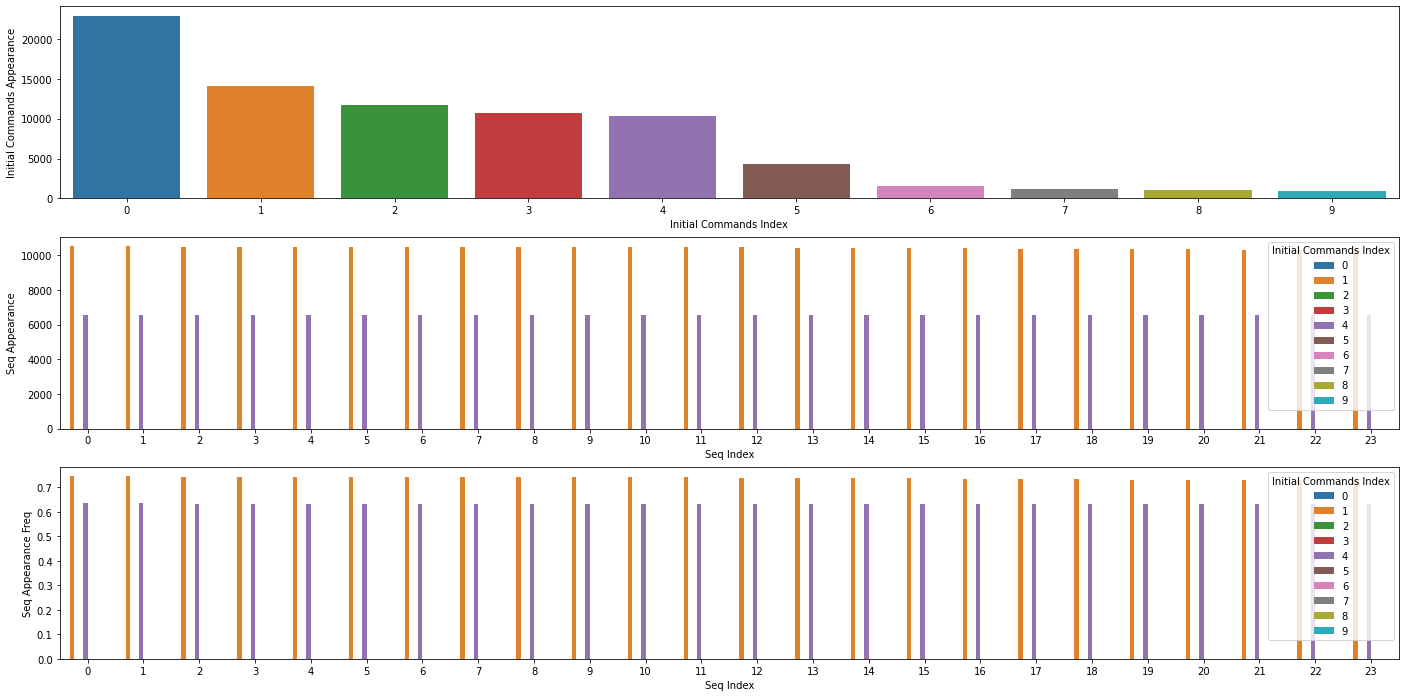

In [35]:
# select top 60-83 frequent sequences
selected_seq_counts_6083 = sorted_seq_counts[60:84]
# dataframe
initial_commands_dat_6083 = make_initial_commands_dat(initialcommandidx, selected_seq_counts_6083, sessions_list)
# plot
fig, ax = plt.subplots(3,1, figsize=(24,12))
sns.barplot(x='Initial Commands Index', y='Initial Commands Appearance', data=initial_commands_dat_6083, ax=ax[0])
sns.barplot(x='Seq Index', y='Seq Appearance', hue='Initial Commands Index', data=initial_commands_dat_6083, ax=ax[1])

sns.barplot(x='Seq Index', y='Seq Appearance Freq', hue='Initial Commands Index', data=initial_commands_dat_6083, ax=ax[2])
plt.show()

#### Seq 84-99

all has a format of /bin/busybox cat /proc/1/exe

In [36]:
sorted_seq_counts[84]

(('/bin/busybox cat /proc/1/exe',
  '/bin/busybox cat /proc/2/exe',
  '/bin/busybox cat /proc/4/exe',
  '/bin/busybox cat /proc/6/exe',
  '/bin/busybox cat /proc/7/exe',
  '/bin/busybox cat /proc/8/exe',
  '/bin/busybox cat /proc/9/exe',
  '/bin/busybox cat /proc/10/exe',
  '/bin/busybox cat /proc/11/exe',
  '/bin/busybox cat /proc/12/exe',
  '/bin/busybox cat /proc/13/exe',
  '/bin/busybox cat /proc/14/exe'),
 16635)

In [37]:
sorted_seq_counts[99]

(('/bin/busybox cat /proc/18/exe',
  '/bin/busybox cat /proc/19/exe',
  '/bin/busybox cat /proc/20/exe',
  '/bin/busybox cat /proc/21/exe',
  '/bin/busybox cat /proc/22/exe',
  '/bin/busybox cat /proc/23/exe',
  '/bin/busybox cat /proc/88/exe',
  '/bin/busybox cat /proc/89/exe',
  '/bin/busybox cat /proc/90/exe',
  '/bin/busybox cat /proc/127/exe',
  '/bin/busybox cat /proc/128/exe',
  '/bin/busybox cat /proc/129/exe'),
 16634)

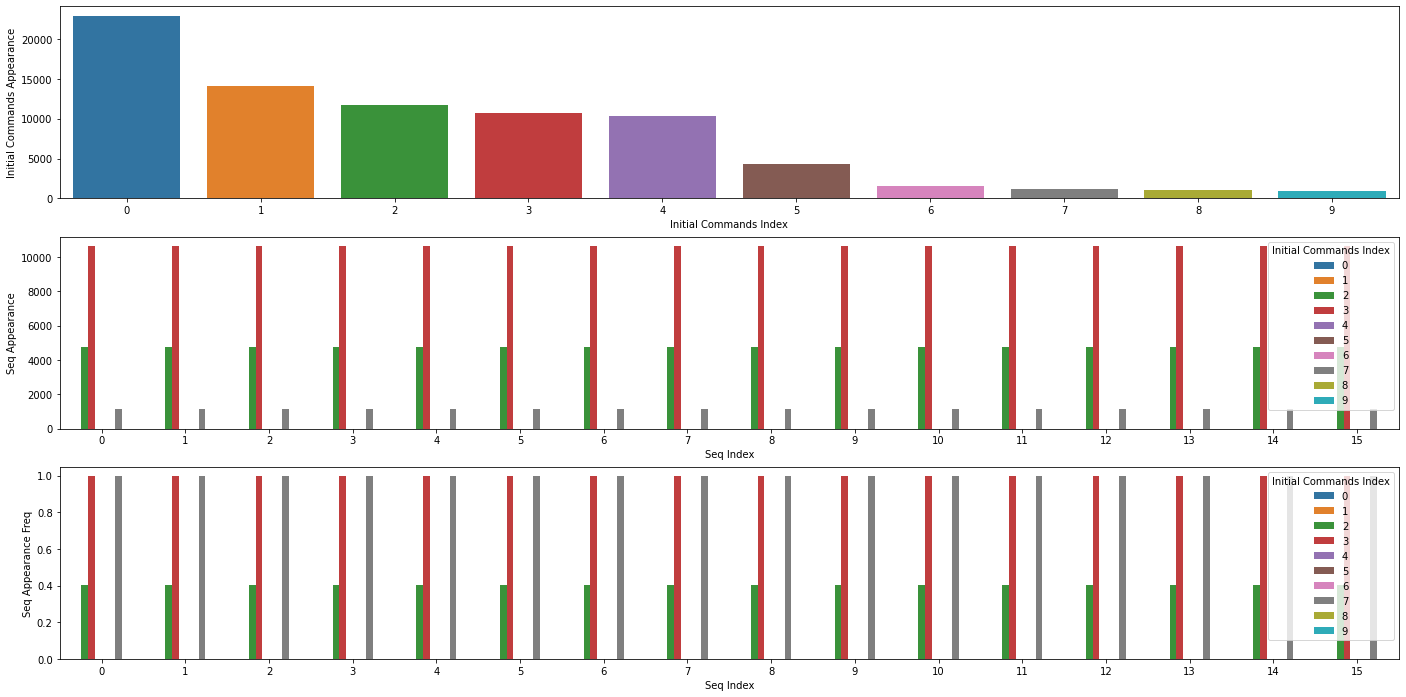

In [38]:
# select top 84-99 frequent sequences
selected_seq_counts_8499 = sorted_seq_counts[84:100]
# dataframe
initial_commands_dat_8499 = make_initial_commands_dat(initialcommandidx, selected_seq_counts_8499, sessions_list)
# plot
fig, ax = plt.subplots(3,1, figsize=(24,12))
sns.barplot(x='Initial Commands Index', y='Initial Commands Appearance', data=initial_commands_dat_8499, ax=ax[0])
sns.barplot(x='Seq Index', y='Seq Appearance', hue='Initial Commands Index', data=initial_commands_dat_8499, ax=ax[1])

sns.barplot(x='Seq Index', y='Seq Appearance Freq', hue='Initial Commands Index', data=initial_commands_dat_8499, ax=ax[2])
plt.show()

### Conclusions

1. inidication that initial commands in a session can help us predict.
2. clusters of sequences encourages us to use length of sequence larger than 12

### More work

1. different length of sequences
2. different number of initial commands

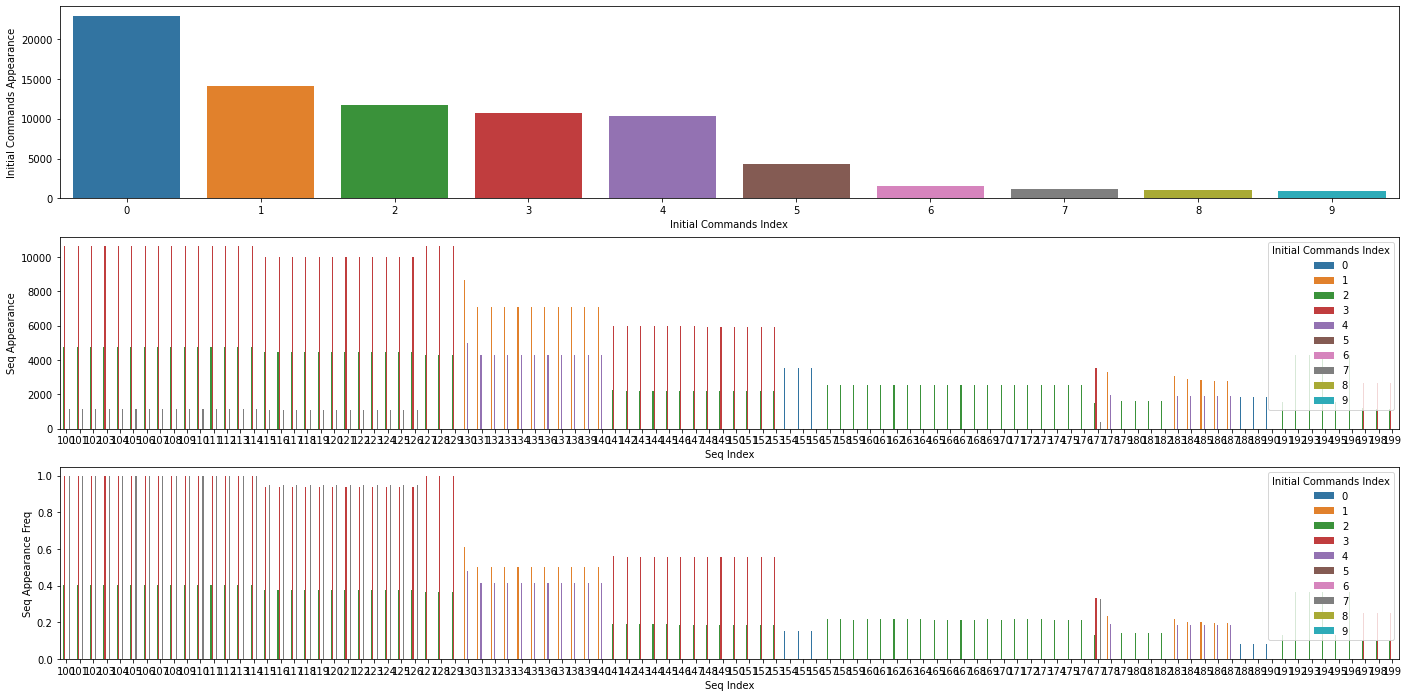

In [45]:
# select top 100-199 frequent sequences
selected_seq_counts_2 = sorted_seq_counts[100:200]
# dataframe
initial_commands_dat_2 = make_initial_commands_dat(initialcommandidx, selected_seq_counts_2, sessions_list)
initial_commands_dat_2['Seq Index'] += 100 
# plot
fig, ax = plt.subplots(3,1, figsize=(24,12))
sns.barplot(x='Initial Commands Index', y='Initial Commands Appearance', data=initial_commands_dat_2, ax=ax[0])
sns.barplot(x='Seq Index', y='Seq Appearance', hue='Initial Commands Index', data=initial_commands_dat_2, ax=ax[1])

sns.barplot(x='Seq Index', y='Seq Appearance Freq', hue='Initial Commands Index', data=initial_commands_dat_2, ax=ax[2])
plt.show()

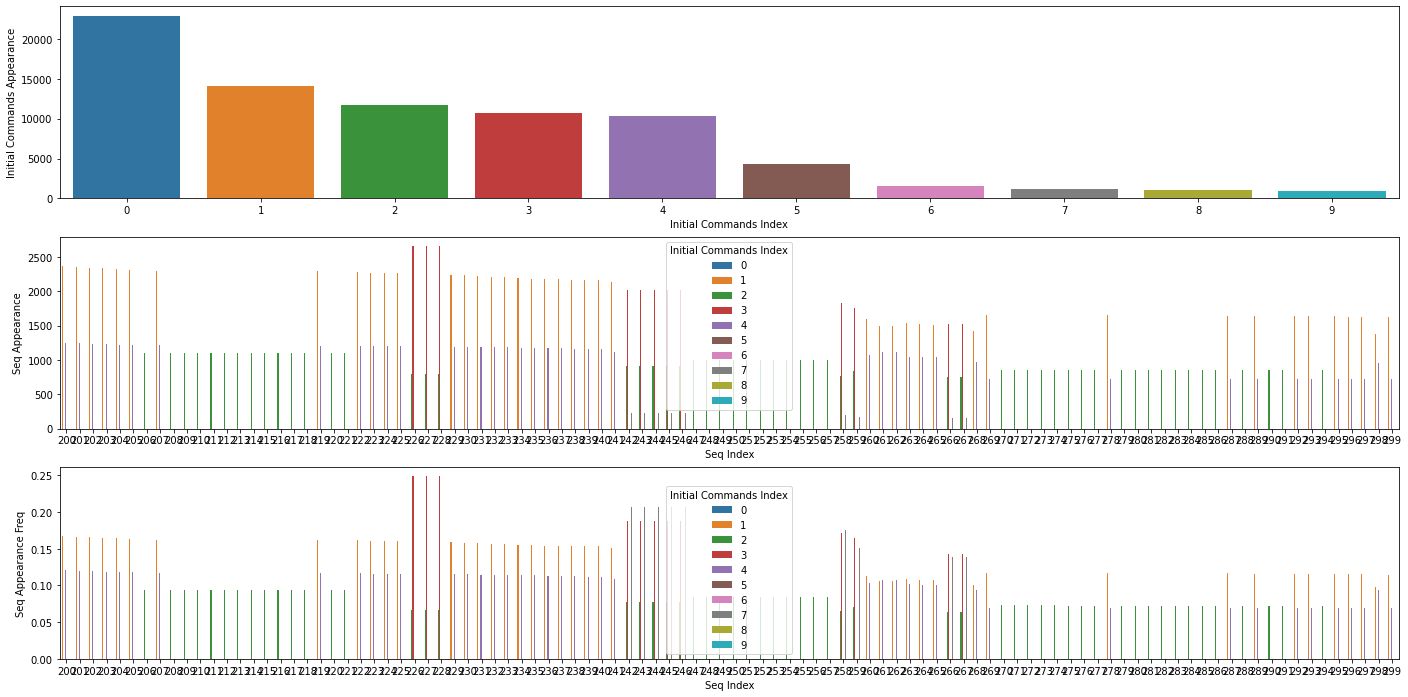

In [46]:
# select top 200-299 frequent sequences
selected_seq_counts_3 = sorted_seq_counts[200:300]
# dataframe
initial_commands_dat_3 = make_initial_commands_dat(initialcommandidx, selected_seq_counts_3, sessions_list)
initial_commands_dat_3['Seq Index'] += 200 
# plot
fig, ax = plt.subplots(3,1, figsize=(24,12))
sns.barplot(x='Initial Commands Index', y='Initial Commands Appearance', data=initial_commands_dat_3, ax=ax[0])
sns.barplot(x='Seq Index', y='Seq Appearance', hue='Initial Commands Index', data=initial_commands_dat_3, ax=ax[1])

sns.barplot(x='Seq Index', y='Seq Appearance Freq', hue='Initial Commands Index', data=initial_commands_dat_3, ax=ax[2])
plt.show()

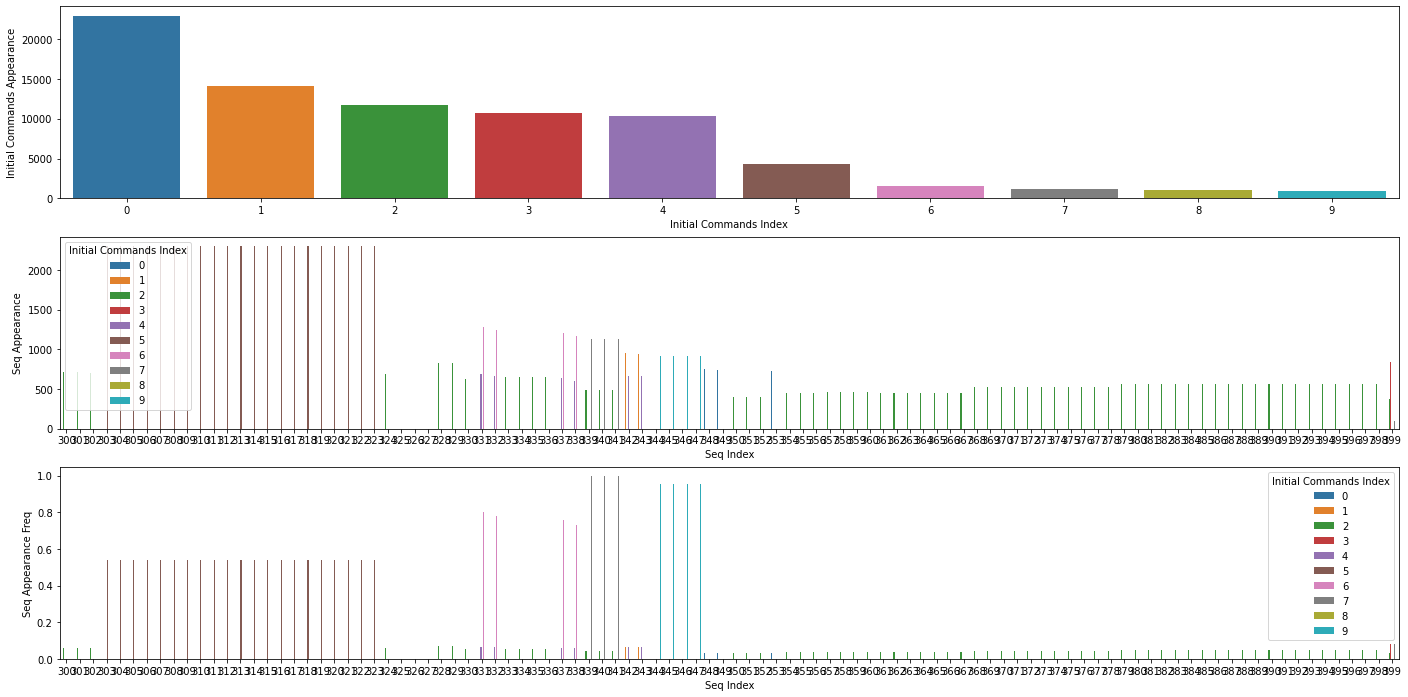

In [47]:
# select top 300-399 frequent sequences
selected_seq_counts_4 = sorted_seq_counts[300:400]
# dataframe
initial_commands_dat_4 = make_initial_commands_dat(initialcommandidx, selected_seq_counts_4, sessions_list)
initial_commands_dat_4['Seq Index'] += 300 
# plot
fig, ax = plt.subplots(3,1, figsize=(24,12))
sns.barplot(x='Initial Commands Index', y='Initial Commands Appearance', data=initial_commands_dat_4, ax=ax[0])
sns.barplot(x='Seq Index', y='Seq Appearance', hue='Initial Commands Index', data=initial_commands_dat_4, ax=ax[1])

sns.barplot(x='Seq Index', y='Seq Appearance Freq', hue='Initial Commands Index', data=initial_commands_dat_4, ax=ax[2])
plt.show()

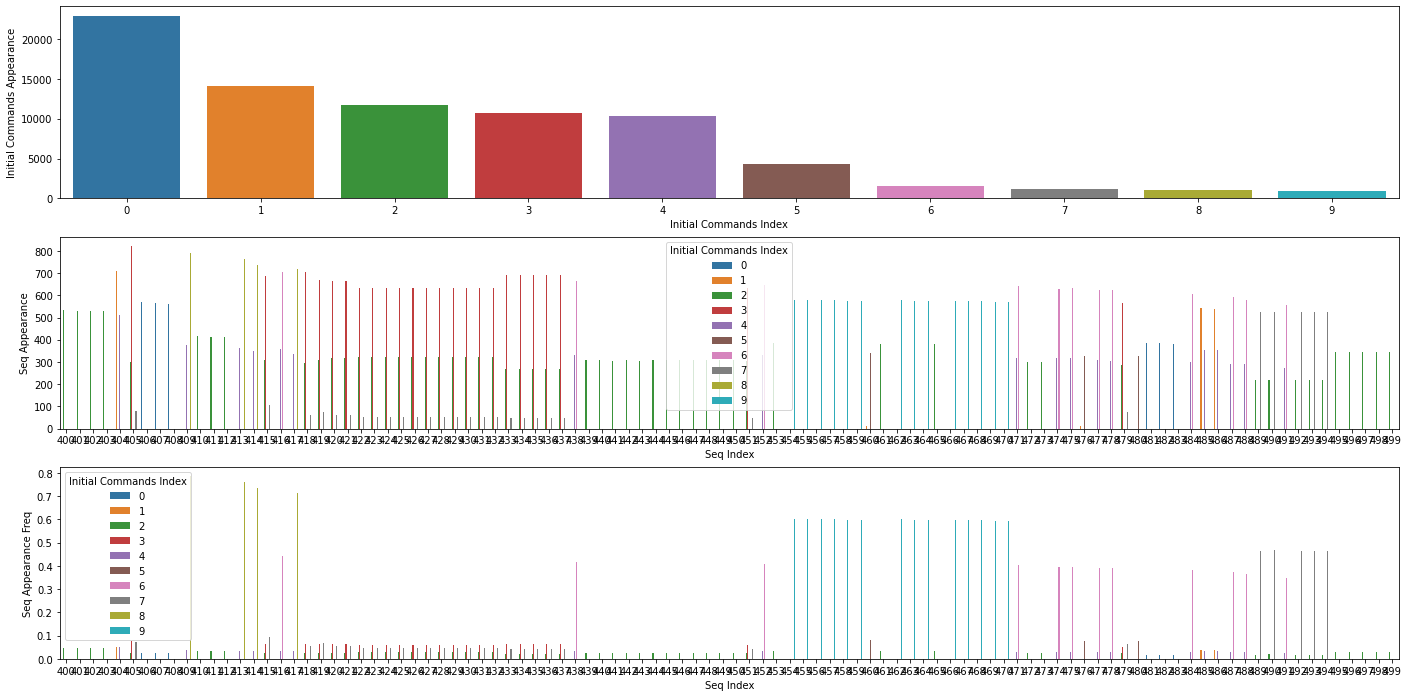

In [48]:
# select top 400-499 frequent sequences
selected_seq_counts_5 = sorted_seq_counts[400:500]
# dataframe
initial_commands_dat_5 = make_initial_commands_dat(initialcommandidx, selected_seq_counts_5, sessions_list)
initial_commands_dat_5['Seq Index'] += 400 
# plot
fig, ax = plt.subplots(3,1, figsize=(24,12))
sns.barplot(x='Initial Commands Index', y='Initial Commands Appearance', data=initial_commands_dat_5, ax=ax[0])
sns.barplot(x='Seq Index', y='Seq Appearance', hue='Initial Commands Index', data=initial_commands_dat_5, ax=ax[1])

sns.barplot(x='Seq Index', y='Seq Appearance Freq', hue='Initial Commands Index', data=initial_commands_dat_5, ax=ax[2])
plt.show()

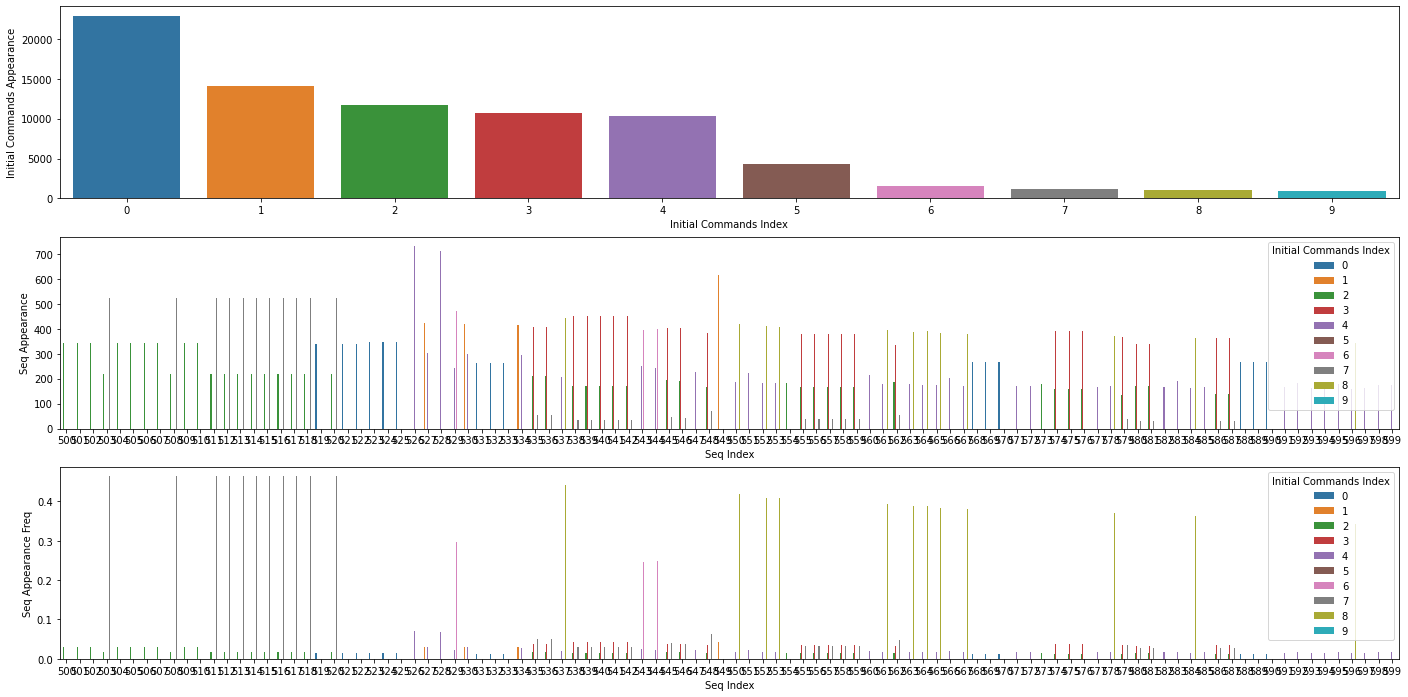

In [49]:
# select top 500-599 frequent sequences
selected_seq_counts_6 = sorted_seq_counts[500:600]
# dataframe
initial_commands_dat_6 = make_initial_commands_dat(initialcommandidx, selected_seq_counts_6, sessions_list)
initial_commands_dat_6['Seq Index'] += 500 
# plot
fig, ax = plt.subplots(3,1, figsize=(24,12))
sns.barplot(x='Initial Commands Index', y='Initial Commands Appearance', data=initial_commands_dat_6, ax=ax[0])
sns.barplot(x='Seq Index', y='Seq Appearance', hue='Initial Commands Index', data=initial_commands_dat_6, ax=ax[1])

sns.barplot(x='Seq Index', y='Seq Appearance Freq', hue='Initial Commands Index', data=initial_commands_dat_6, ax=ax[2])
plt.show()

In [50]:
# from gensim.corpora import Dictionary
# dictionary = Dictionary([tokenizer.tokenize(
#     commands_list[2][-2]), tokenizer.tokenize(commands_list[2][-3])])
# dictionary.filter_extremes(no_below=2, no_above=0.1)

In [41]:
# from nltk.tokenize import RegexpTokenizer
# # process data
# # removes special characters like '/', and also separates by these
# # using regexp that looks nice
# tokenizer = RegexpTokenizer(r'[a-zA-Z0-9_\.\-\*]+')
# token_list = []
# for command in all_commands_list:
#     token_list += [tokenizer.tokenize(command)]

In [42]:
# from gensim.corpora import Dictionary
# dictionary = Dictionary(token_list)
# # dictionary.filter_extremes(no_below=20, no_above=0.5)
# # corpus = [dic.doc2bow(token_list)]

In [43]:
# def clean_msdat(dat):
#     for row in range(dat.shape[0]):
#         if '.' not in dat.loc[row,'LastSeen'][-4:-1]:
#             dat.loc[row,'LastSeen']+='.0'
#         if '.' not in dat.loc[row,'FirstSeen'][-4:-1]:
#             dat.loc[row,'FirstSeen']+='.0'
#         dat.loc[row, 'TimeSpan'] = datetime.timestamp(datetime.strptime(dat.loc[row,'LastSeen'], '%Y-%m-%dT%H:%M:%S.%f'))-\
#         datetime.timestamp(datetime.strptime(dat.loc[row,'FirstSeen'], '%Y-%m-%dT%H:%M:%S.%f'))
#     dat.loc[:,'Rate'] = dat.loc[:,'TimesSeen']/dat.loc[:,'TimeSpan']


In [44]:
# clean_msdat(msdat)


In [45]:
# #! /usr/bin/env python
# import os
# import json
# import zipfile
# #from geoip import geolite2
# #import pytz,datetime
# #from dateutil.parser import parse
# path = "/home/hpms"
# # def parse_date(t):
# #    return(parse(t).timestamp())
# directory = os.fsencode(path)
# for file in os.listdir(directory):
#     fname = os.fsdecode(file)
#     if fname.endswith(".zip"):
#         with zipfile.ZipFile(os.path.join(path, fname)) as z:
#             for filename in z.namelist():
#                 if not os.path.isdir(filename):
#                     with z.open(filename) as json_file:
#                         data = json.load(json_file)
# #                        ipa,ip_protocol,protocol,port = data['IPAddress'],data['IPProtocol'],data['Protocol'],data['Port']
#                         commands = data['Commands']
#                         #match = geolite2.lookup(ipa)
# #                        os_=data['OSDetectionInfo']['OS']
# #                        fc,lc = map(parse_date,(data['FirstConnection'],data['LastConnection']))
# #                        os_ = "??" if os_ is None else os_
#                         #country="??" if match is None else match.country
#                         if commands != []:
#                             #                            print(ipa,ip_protocol,protocol,port,os_,fc,lc,commands,detailed_commands)
#                             print(data)
# #                        else:
# #                            print(ipa,ip_protocol,protocol,port,country,os_,fc,lc)


In [46]:
# #! /usr/bin/env python
# import os
# import json
# import zipfile
# #from geoip import geolite2
# #import pytz,datetime
# #from dateutil.parser import parse
# path = "/home/hpms"
# # def parse_date(t):
# #    return(parse(t).timestamp())
# directory = os.fsencode(path)
# fname = os.fsdecode('43107.zip')
# if fname.endswith(".zip"):
#     with zipfile.ZipFile(os.path.join(path, fname)) as z:
#         for filename in z.namelist():
#             if not os.path.isdir(filename):
#                 with z.open(filename) as json_file:
#                     data = json.load(json_file)
# #                        ipa,ip_protocol,protocol,port = data['IPAddress'],data['IPProtocol'],data['Protocol'],data['Port']
#                     commands = data['Commands']
#                     #match = geolite2.lookup(ipa)
# #                        os_=data['OSDetectionInfo']['OS']
# #                        fc,lc = map(parse_date,(data['FirstConnection'],data['LastConnection']))
# #                        os_ = "??" if os_ is None else os_
#                     #country="??" if match is None else match.country
#                     if commands != []:
#                         #                            print(ipa,ip_protocol,protocol,port,os_,fc,lc,commands,detailed_commands)
#                         print(data)
# #                        else:
# #                            print(ipa,ip_protocol,protocol,port,country,os_,fc,lc)
